# Выбор локации для скважины

## Описание проекта
Добывающей компании нужно решить где бурить новую скважину. Предоставлены пробы в трёх регионах.
## Задача
С помощью техники Bootstrap необходимо построить модель для определения региона, где добыча принесет наибольшую прибыль, а вероятность убытков меньше 2.5%.

## Исходные данные
Данные геологоразведки трёх регионов находятся в файлах: geo_data_0.csv, geo_data_1.csv, geo_data2.csv
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек);
- product — объём запасов в скважине (тыс. баррелей).
Дополнительные условия:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемы).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- Доход с каждой 1000 баррелей продукта составляет 450 тыс. руб.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка данных

Проведем настрйоки Jupyter Notebook (отключение предупреждений) и сделам импорт необходимых библиотек.

In [1]:
# Игнгорирование предупреждений системы
import warnings
warnings.filterwarnings("ignore")

In [2]:
! pip install -q phik
! pip install -q sweetviz
! pip install -U -q ydata-profiling[notebook]
# ! jupyter nbextension enable --py widgetsnbextension

In [3]:
# Импорт необходимых билиотек
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import sweetviz as sv
from ydata_profiling import ProfileReport

# отображаем все столбцы и до 100 строк
pd.options.display.max_columns = 250
pd.options.display.max_rows = 100
#pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:20.2f}'.format

RANDOM_STATE = 42
TEST_SIZE = 0.25

Загружаем первый датасет - смотрим визуально на данные, смотрим на описание данных

,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,0.50,0.25,2.50,92.50
std,0.87,0.50,3.25,44.29
min,-1.41,-0.85,-12.09,0.00
25%,-0.07,-0.20,0.29,56.50
50%,0.50,0.25,2.52,91.85
75%,1.07,0.70,4.72,128.56
max,2.36,1.34,16.00,185.36


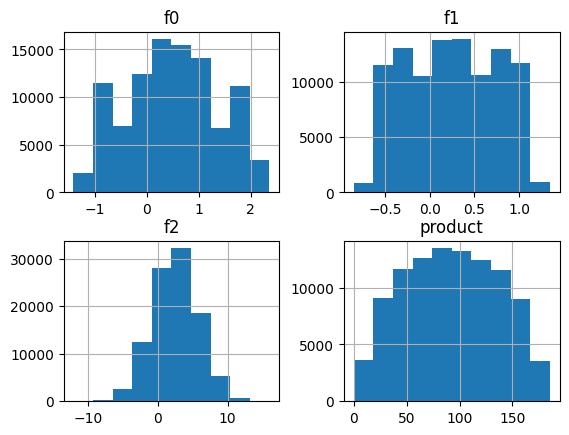

In [4]:
geo_data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
display(geo_data_0.head())
display(geo_data_0.info())
display(geo_data_0.describe())
geo_data_0.hist();

Пропусков в данных нет, данные носят числовой хаарактер. Представлено 100 тыс строк данных. Далее проверяем на наличие дубликатов. Воспользуемся специальной функцией.

In [5]:
def descr(df):
    '''
    Функция принимает датафрейм и выдает таблицу ключевых значений 
    по числовым и категориальным столбцам в компактном виде.
    '''
    df_describe = pd.DataFrame()
    for col in df.columns: 
        if df[col].dtypes in df.select_dtypes(include='number').dtypes.unique():
            df_describe[col] = [
                df[col].dtypes,
                df[col].isna().count(),
                df[col].count(),
                df[col].isna().sum(), 
                round(100*df[col].isna().sum()/df[col].isna().count(), 2),
                df[col].nunique(),
                df[col].min(),
                df[col].max(),
                df[col].duplicated().sum(),
                df[col].sort_values().unique()
            ]
        else:
            df_describe[col] = [
            df[col].dtypes,
            df[col].isna().count(),
            df[col].count(),
            df[col].isna().sum(), 
            round(100*df[col].isna().sum()/df[col].isna().count(), 2),
            df[col].nunique(),
            '-', 
            '-',
            df[col].duplicated().sum(),
            df[col].sort_values().unique()
        ]

    df_describe = df_describe.T
    df_describe.columns = ['Тип данных', 'Количество строк', 'Строк без пропусков', 'Количество пропусков', 'Пропуски, %', 'Количество уникальных', 'Минимум', 'Максимум', 'Количество дубликатов', 'Сэмпл']
    df_describe = df_describe.T
    return df_describe

In [6]:
descr(geo_data_0)

,id,f0,f1,f2,product
Тип данных,object,float64,float64,float64,float64
Количество строк,100000,100000,100000,100000,100000
Строк без пропусков,100000,100000,100000,100000,100000
Количество пропусков,0,0,0,0,0
"Пропуски, %",0.00,0.00,0.00,0.00,0.00
Количество уникальных,99990,100000,100000,100000,100000
Минимум,-,-1.41,-0.85,-12.09,0.00
Максимум,-,2.36,1.34,16.00,185.36
Количество дубликатов,10,0,0,0,0
Сэмпл,"[006OJ, 009eY, 00AfQ, 00AuZ, 00BTM, 00CoD, 00K...","[-1.408605306026996, -1.3517729921635937, -1.3...","[-0.8482184970082173, -0.8449079224879839, -0....","[-12.08832811806336, -10.138341352347217, -10....","[0.0, 0.0040215231561772, 0.0061136363115587, ..."


Есть 10 строчек с дублирующимися id - удаляем повторы, оставляем первые значения. Проверяем.

In [7]:
df0 = geo_data_0.drop_duplicates(subset='id', keep='first')
df0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99990 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99990 non-null  object 
 1   f0       99990 non-null  float64
 2   f1       99990 non-null  float64
 3   f2       99990 non-null  float64
 4   product  99990 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


Повторяем те же действия для двух оставшихся файлов.

,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-0.01,3.18
1,62mP7,14.27,-3.48,1.00,26.95
2,vyE1P,6.26,-5.95,5.00,134.77
3,KcrkZ,-13.08,-11.51,5.00,137.95
4,AHL4O,12.70,-8.15,5.00,134.77


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,1.14,-4.80,2.49,68.83
std,8.97,5.12,1.70,45.94
min,-31.61,-26.36,-0.02,0.00
25%,-6.30,-8.27,1.00,26.95
50%,1.15,-4.81,2.01,57.09
75%,8.62,-1.33,4.00,107.81
max,29.42,18.73,5.02,137.95


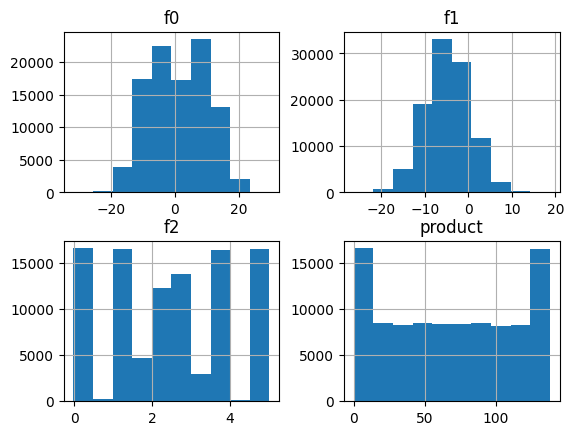

In [8]:
geo_data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
display(geo_data_1.head())
display(geo_data_1.info())
display(geo_data_1.describe())
geo_data_1.hist();

Во фрейме 100 тыс записей. Характер расспределения данных на гистограммах выглядит оригинально). В условии уговорено, что данные синтетические. Проверяем на повторы.

In [9]:
descr(geo_data_1)

,id,f0,f1,f2,product
Тип данных,object,float64,float64,float64,float64
Количество строк,100000,100000,100000,100000,100000
Строк без пропусков,100000,100000,100000,100000,100000
Количество пропусков,0,0,0,0,0
"Пропуски, %",0.00,0.00,0.00,0.00,0.00
Количество уникальных,99996,100000,100000,100000,12
Минимум,-,-31.61,-26.36,-0.02,0.00
Максимум,-,29.42,18.73,5.02,137.95
Количество дубликатов,4,0,0,0,99988
Сэмпл,"[0022J, 003Gl, 003Vx, 004LG, 006oG, 008Zq, 00D...","[-31.609576019167687, -27.829616136400016, -26...","[-26.358598008345872, -25.389622416296945, -25...","[-0.0181440867134202, -0.0178866789857535, -0....","[0.0, 3.179102583207246, 26.95326103153969, 30..."


Есть 4 повторяющиеся записи. Удаляем, проверяем.

In [10]:
df1 = geo_data_1.drop_duplicates(subset='id', keep='first')
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99996 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99996 non-null  object 
 1   f0       99996 non-null  float64
 2   f1       99996 non-null  float64
 3   f2       99996 non-null  float64
 4   product  99996 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,0.00,-0.00,2.50,95.00
std,1.73,1.73,3.47,44.75
min,-8.76,-7.08,-11.97,0.00
25%,-1.16,-1.17,0.13,59.45
50%,0.01,-0.01,2.48,94.93
75%,1.16,1.16,4.86,130.60
max,7.24,7.84,16.74,190.03


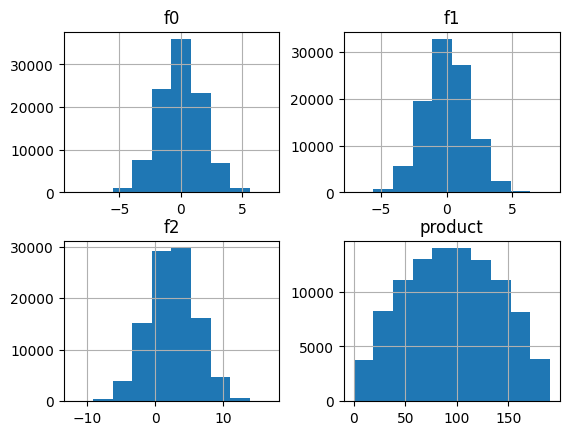

In [11]:
geo_data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')
display(geo_data_2.head())
display(geo_data_2.info())
display(geo_data_2.describe())
geo_data_2.hist();

Пропусков нет. 100 тыс записей. Проверяем на повторы.

In [12]:
descr(geo_data_2)

,id,f0,f1,f2,product
Тип данных,object,float64,float64,float64,float64
Количество строк,100000,100000,100000,100000,100000
Строк без пропусков,100000,100000,100000,100000,100000
Количество пропусков,0,0,0,0,0
"Пропуски, %",0.00,0.00,0.00,0.00,0.00
Количество уникальных,99996,100000,100000,100000,100000
Минимум,-,-8.76,-7.08,-11.97,0.00
Максимум,-,7.24,7.84,16.74,190.03
Количество дубликатов,4,0,0,0,0
Сэмпл,"[009Gl, 00AuD, 00CaL, 00Cby, 00NQN, 00NhF, 00Q...","[-8.760003624213763, -7.450587110708628, -7.18...","[-7.084019760867246, -6.748356769522671, -6.73...","[-11.97033454147699, -11.611690484056377, -11....","[0.0, 0.0046060000398026, 0.0092041119595402, ..."


Повторы есть. Удаляем. Проверяем.

In [13]:
df2 = geo_data_2.drop_duplicates(subset='id', keep='first')
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99996 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99996 non-null  object 
 1   f0       99996 non-null  float64
 2   f1       99996 non-null  float64
 3   f2       99996 non-null  float64
 4   product  99996 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


Геоданные в 3 датафрейах подготовлены - df0, df1, df2.

Дополнительно для комплексного осмотра данных применим специализированные сторонние библиотеки. 

                                             |                                                                …


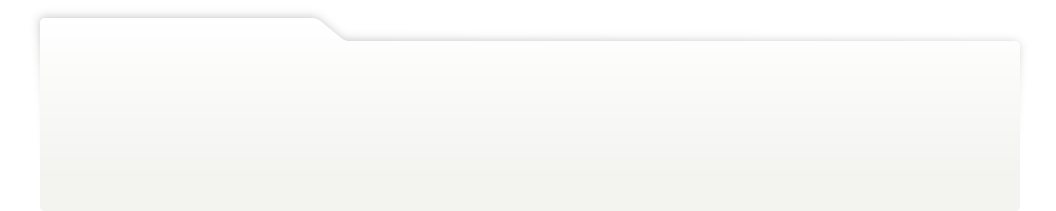
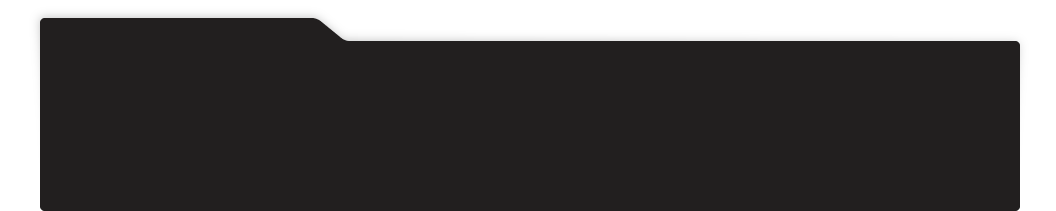
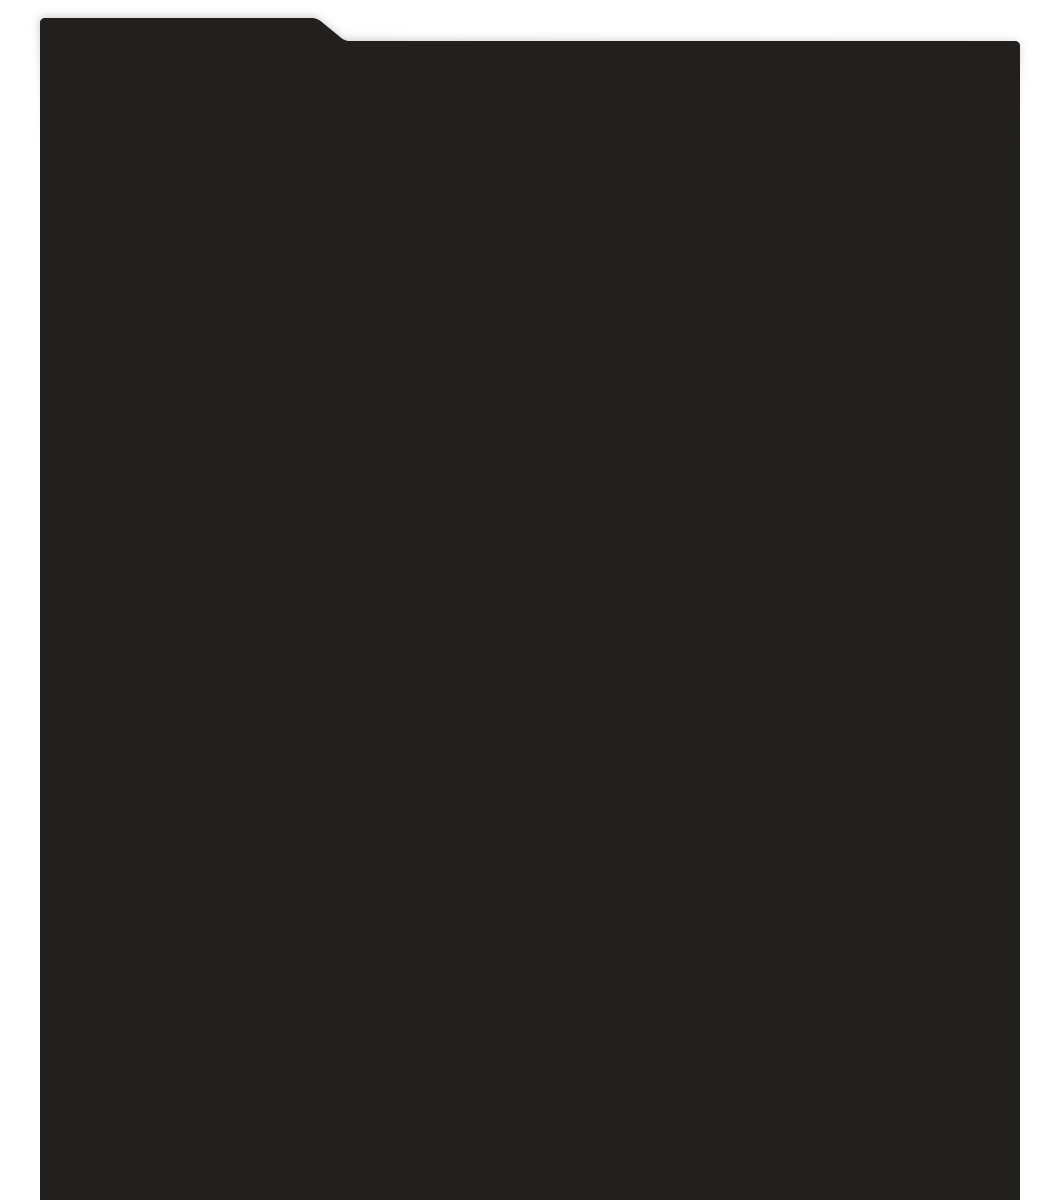
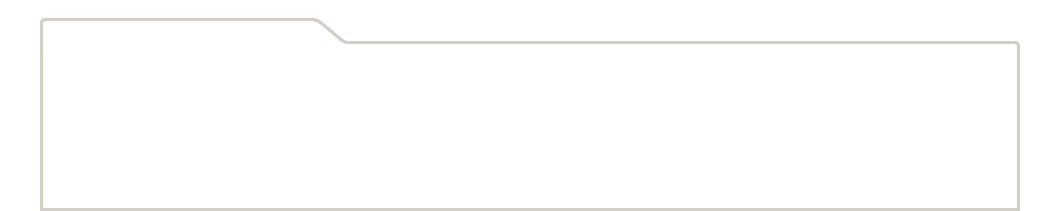
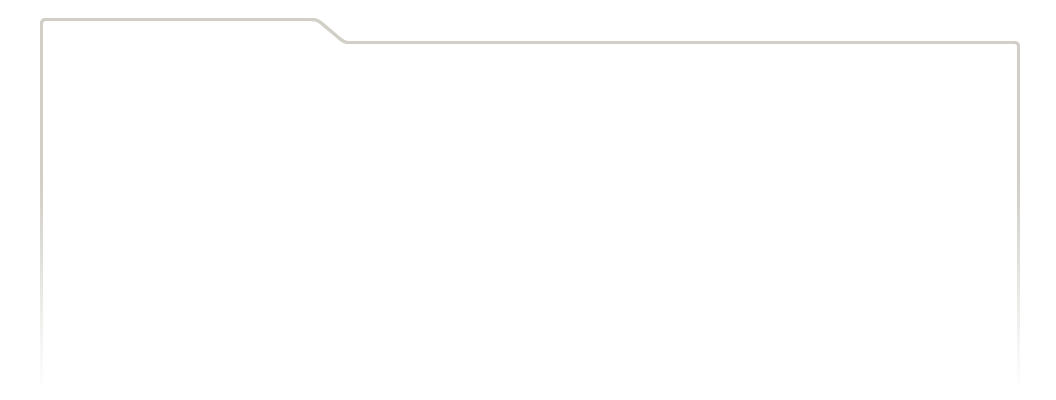
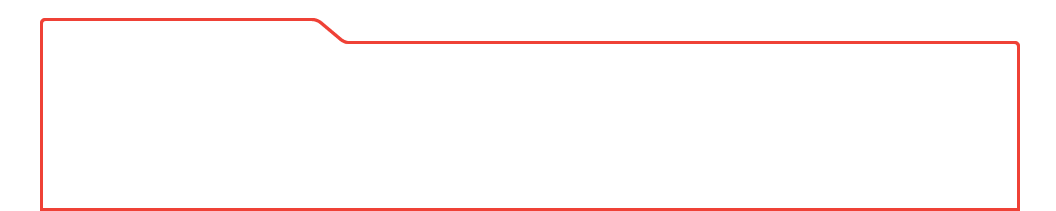
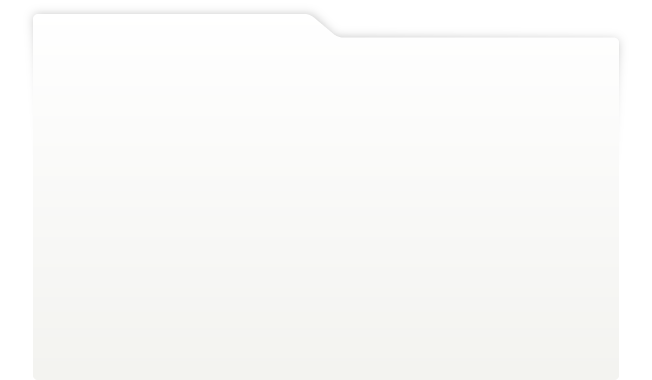
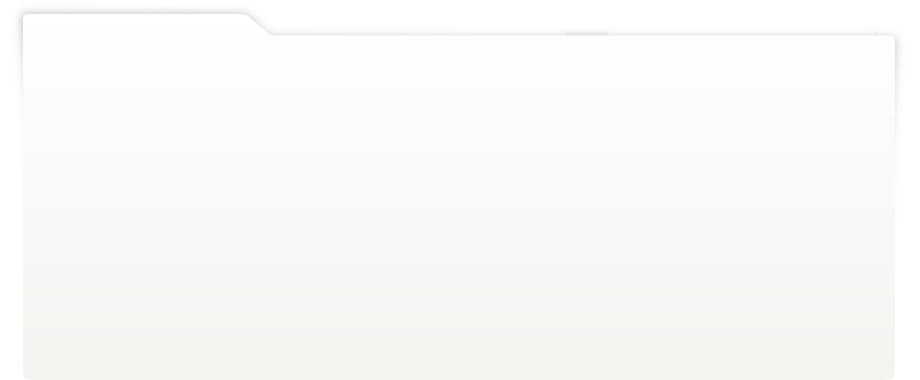
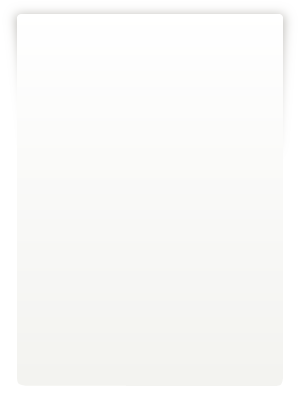
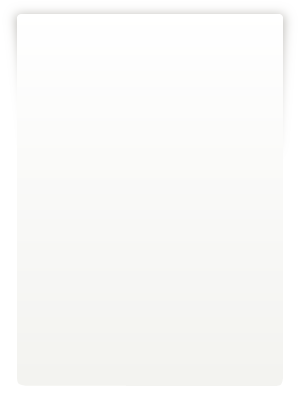
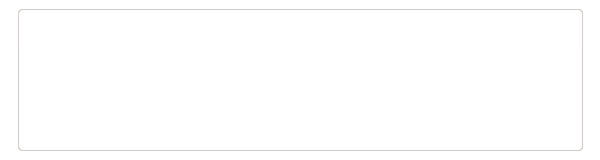
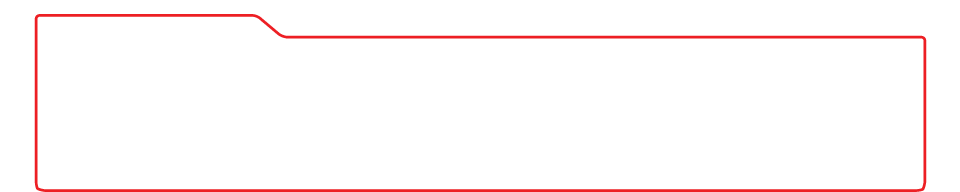
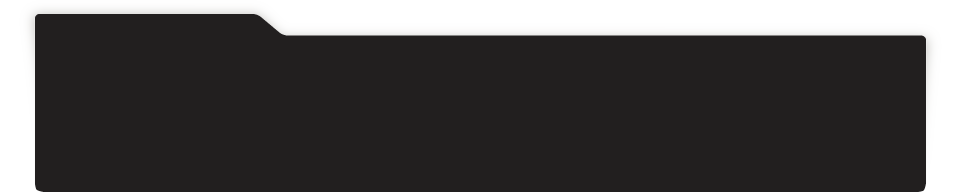
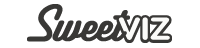
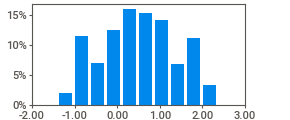
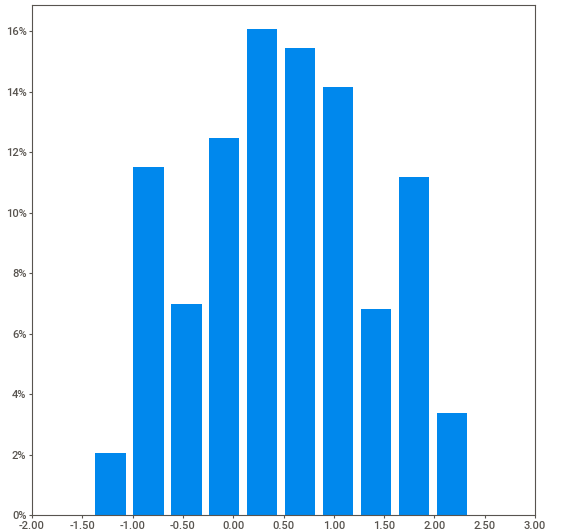
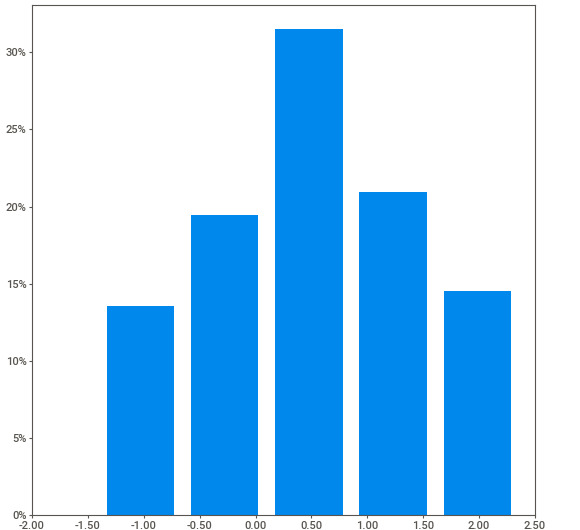
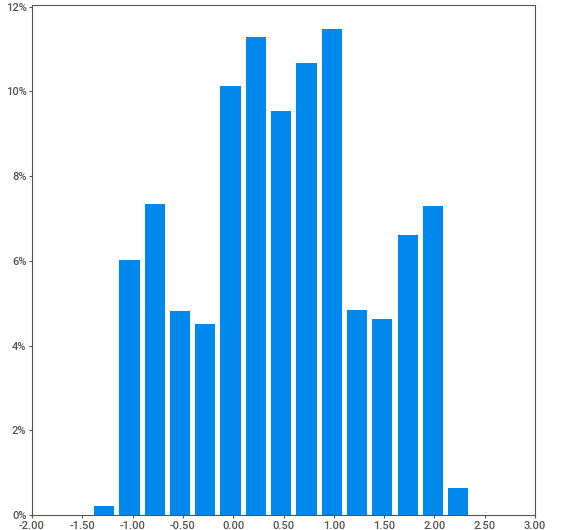
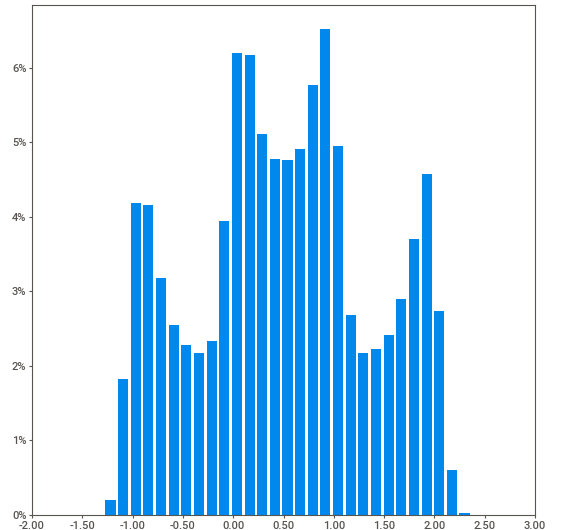
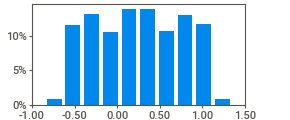
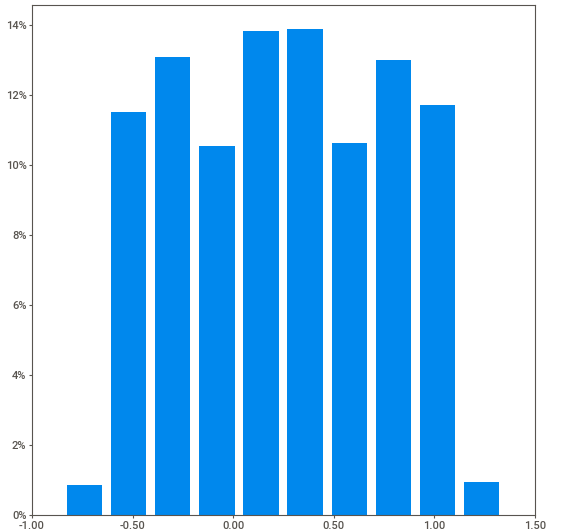
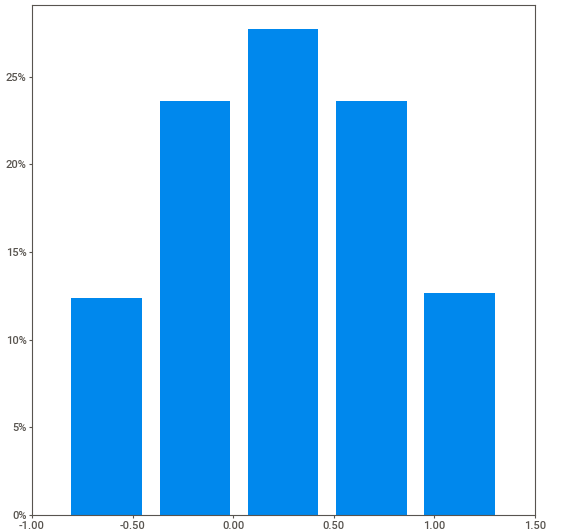
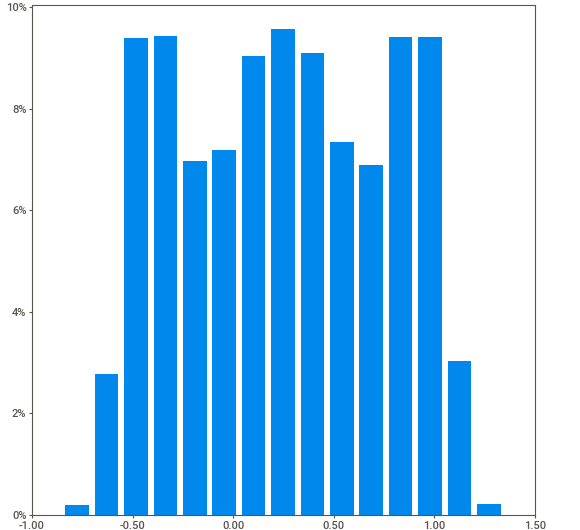
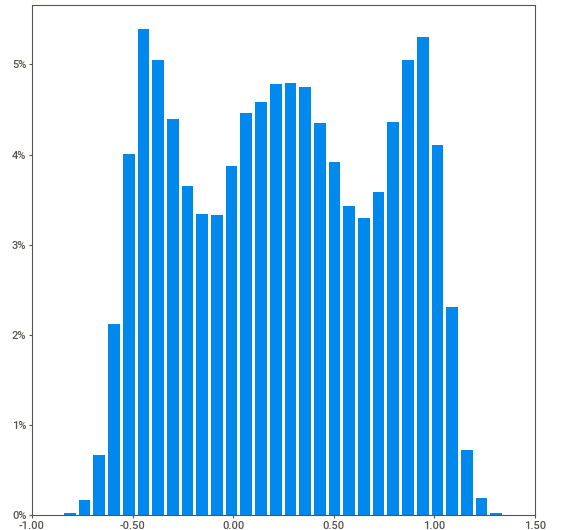
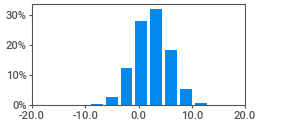
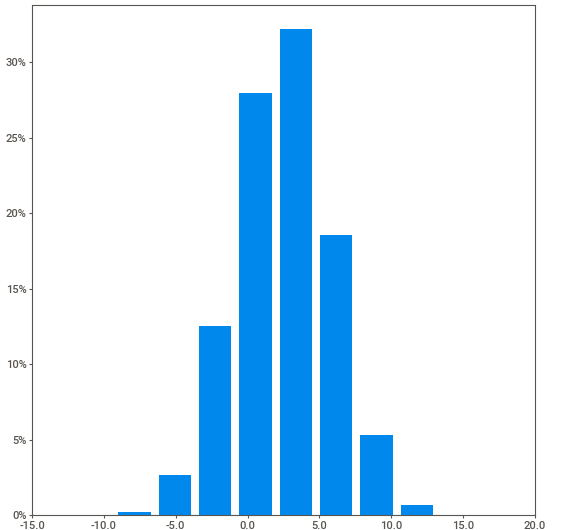
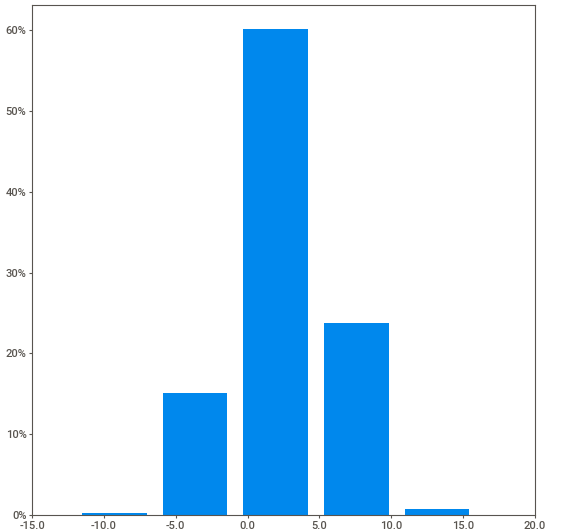
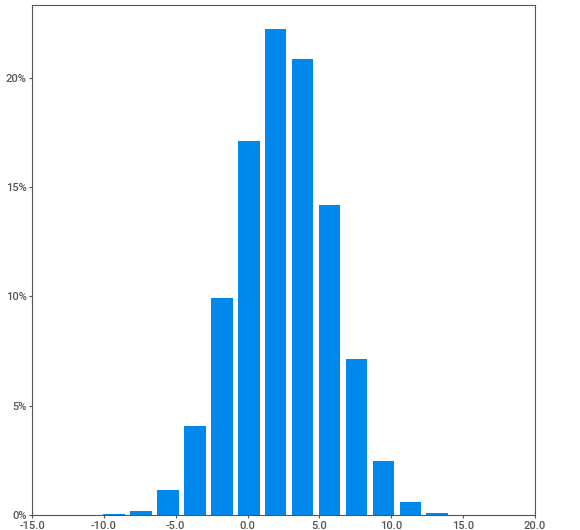
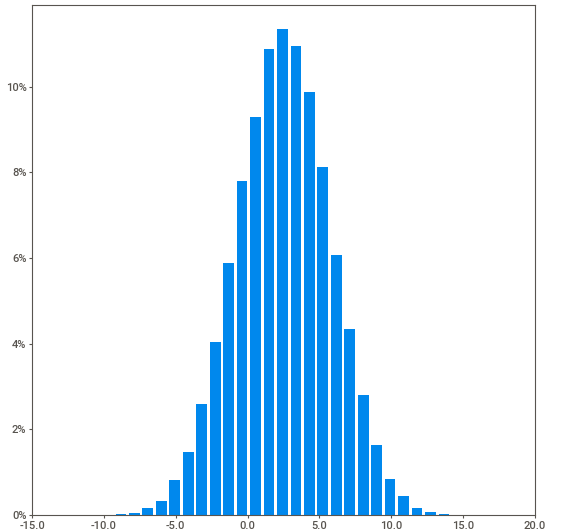
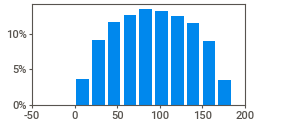
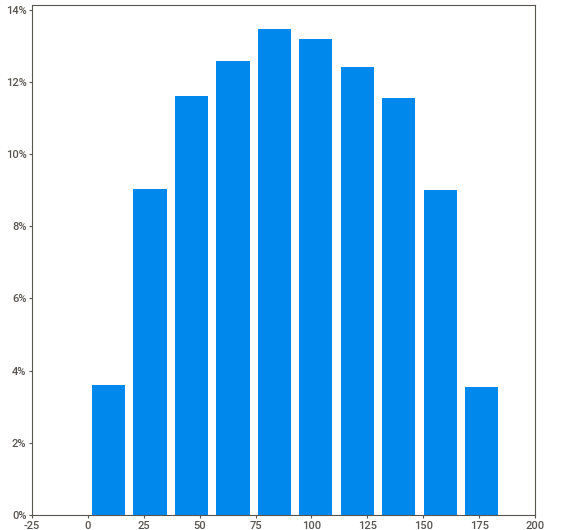
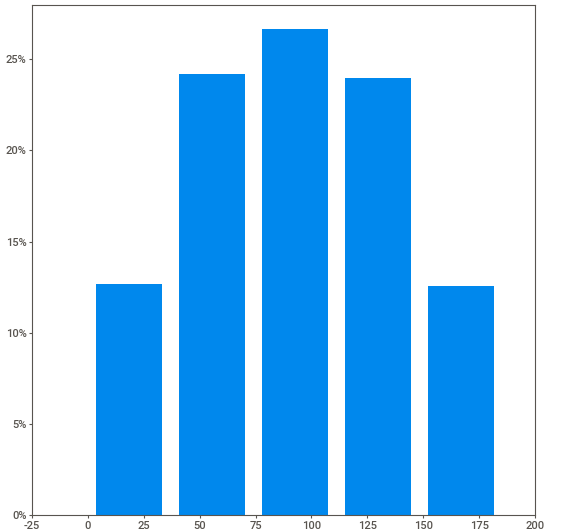
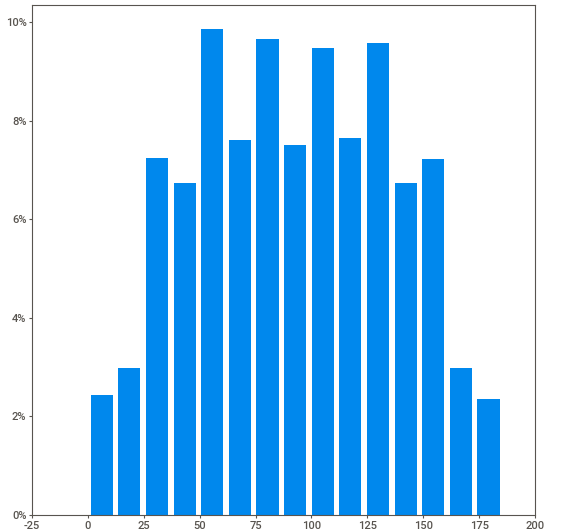
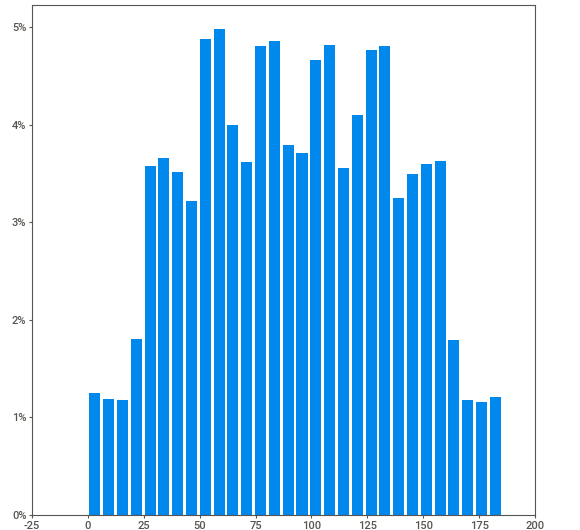
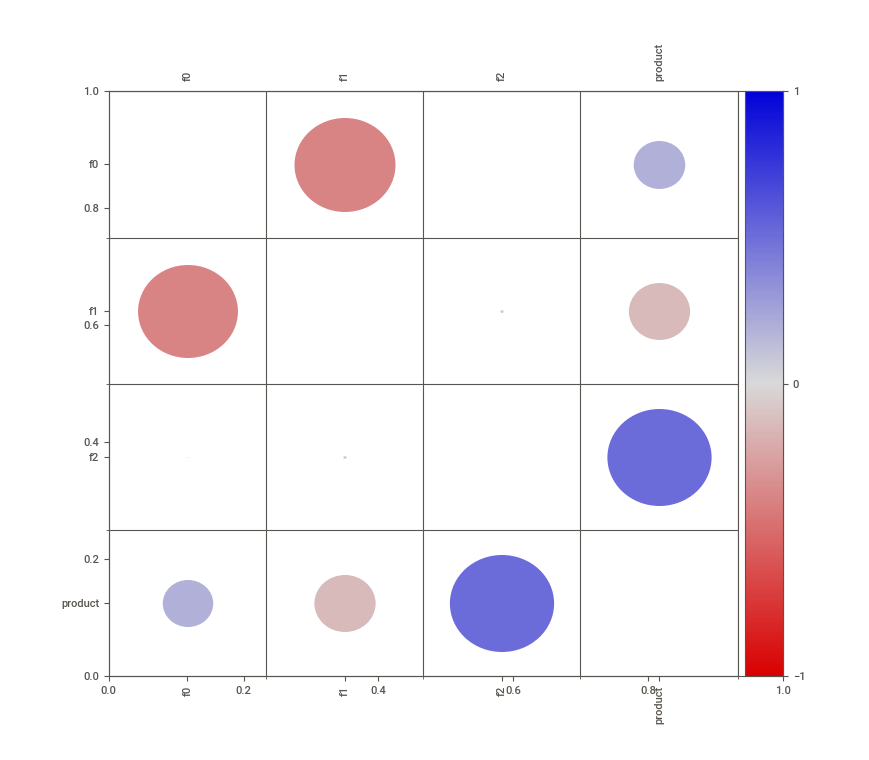
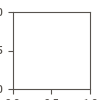

In [14]:
report = sv.analyze([df0, 'Регион 0'])
report.show_notebook()

In [15]:
profile = ProfileReport(df0, title='Регион 0')
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
profile.to_widgets()

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

,f0,f1,f2,product
f0,1.00,-0.47,-0.00,0.13
f1,-0.47,1.00,0.00,-0.18
f2,-0.00,0.00,1.00,0.49
product,0.13,-0.18,0.49,1.00


,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04
5,wX4Hy,0.97,0.49,-0.74,64.74
6,tL6pL,0.65,0.53,1.78,49.06
7,BYPU6,-0.40,0.81,-5.62,72.94
8,j9Oui,0.64,-0.55,2.37,113.36
9,OLuZU,2.17,0.56,9.44,127.91


,id,f0,f1,f2,product
99990,uQHju,-0.17,0.99,5.15,121.25
99991,5aJ79,-0.88,0.17,6.96,152.61
99992,vgK5D,0.64,0.75,2.92,95.18
99993,sOhIk,-0.18,0.91,5.24,89.62
99994,hWIah,1.56,-0.31,1.32,50.09
99995,DLsed,0.97,0.37,6.08,110.74
99996,QKivN,1.39,-0.38,1.27,122.35
99997,3rnvd,1.03,0.02,-1.35,64.38
99998,7kl59,1.00,-0.53,1.58,74.04
99999,1CWhH,1.76,-0.27,5.72,149.63


## Обучение и проверка модели для каждого региона
### Для 0 региона

Поскольку манипуляции с данными носят повторяющийся характер целесообразно будет использовать функцию, которая делит данные, строит диаграммы, скалирует, обучает, оценивает модель и возвращает датафрейм с целевым и предсказанными объемом сырья в скважинах для валидационной выборки.

In [17]:
def well(df):
    '''
    Функция принимает на вход датафрейм с данными региона, 
    делит данные, строит диаграммы, скалирует, обучает, оценивает модель,
    возвращает предсказанные и целевые данные по региону.
    '''
    X = df.drop(['id', 'product'], axis=1)
    y = df['product']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    X_train.plot(kind='hist', bins=50, ax=axes[0], alpha=0.4)
    axes[0].set_title('Гистограмма распределения')
    X_train.plot(kind='box', ax=axes[1], rot=45)
    axes[1].set_title('Разброс значений признаков')
    plt.show()
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    lr_model = LinearRegression()
    lr_model.fit(X_train_scaled, y_train)
    # print(lr_model_0.coef_, lr_model_0.intercept_)
    predictions = lr_model.predict(X_test_scaled)
    
    y_test.name = 'valid'
    pred = pd.Series(predictions)
    pred.name = 'pred'
    reg = pd.concat([pred, y_test.reset_index(drop=True)], axis=1)
    # display(reg.head())
    
    # print(predictions[1], y_test.reset_index(drop=True)[1])
    sns.heatmap(df.drop(['id'], axis=1).corr(), annot=True, fmt='.2f');
    plt.show();
    
    rmse = mean_squared_error(y_test, predictions, squared=False)
    print('Средний предсказанный запас сырья в регионе:', predictions.mean().round(2), 'тыс. баррелей')
    print('Среднеквадратичная ошибка модели:', rmse.round(2))
    return reg

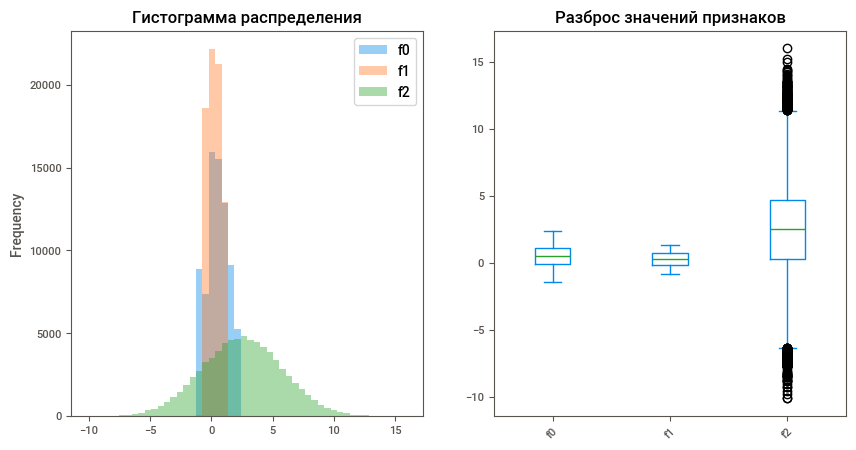

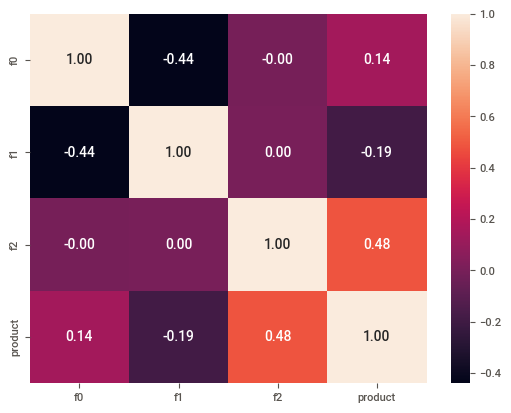

Средний предсказанный запас сырья в регионе: 92.61 тыс. баррелей
Среднеквадратичная ошибка модели: 37.69


In [18]:
reg_0 = well(df0)

Анализ региона 0:
- Довольно большая среднеквадратичная ошибка.
- Средний предсказанный запас сырья в 0 регионе: 92.61.
- Среднеквадратичная ошибка 0 модели: 37.69.


### Для 1 региона

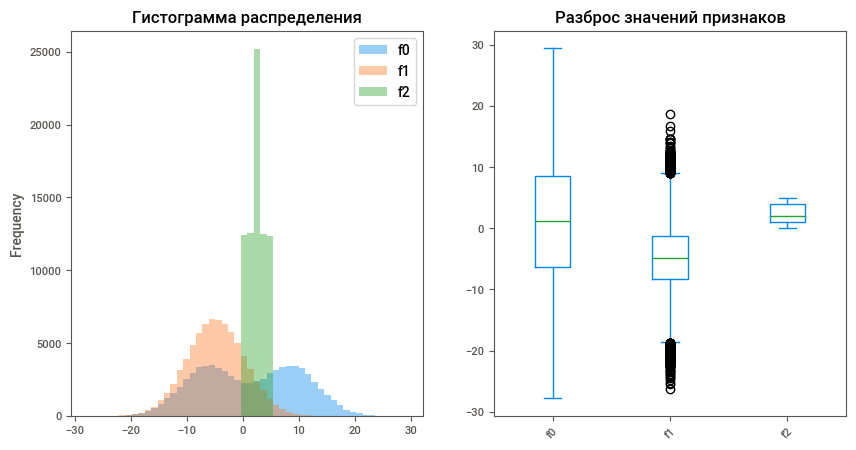

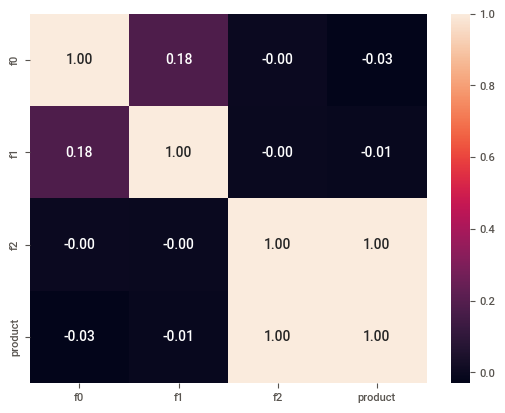

Средний предсказанный запас сырья в регионе: 68.58 тыс. баррелей
Среднеквадратичная ошибка модели: 0.89


In [19]:
reg_1 = well(df1)

Анализ региона 1:
- Довольно большая среднеквадратичная ошибка.
- Средний предсказанный запас сырья в 1 регионе: 68.58.
- Среднеквадратичная ошибка 1 модели: 0.89.

### Для 2 региона

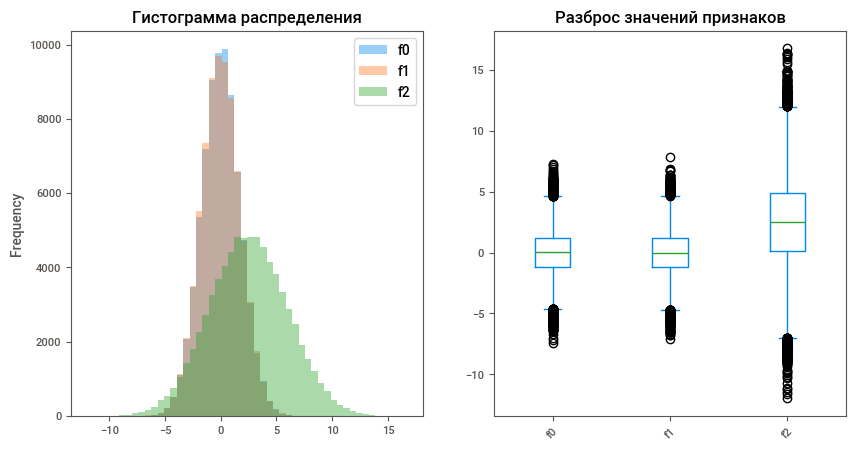

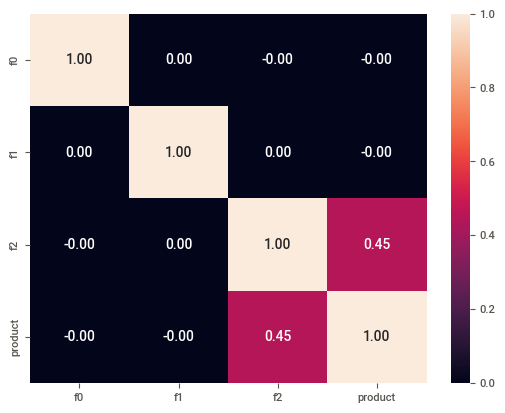

Средний предсказанный запас сырья в регионе: 94.93 тыс. баррелей
Среднеквадратичная ошибка модели: 40.08


In [20]:
reg_2 = well(df2)

Анализ региона 2:

Довольно большая среднеквадратичная ошибка.
Средний предсказанный запас сырья во 2 регионе: 94.93.
Среднеквадратичная ошибка 2 модели: 40.08.

У нас получилось 3 датафрейма с результатами прогноза и проверочным значением сырья: reg_0, reg_1, reg_2

## Расчёт прибыли
Все ключевые значения для расчётов сохраняем в отдельных переменных.

In [21]:
QUANTITY = 200 # Выбирают 200 лучших скважин.
BUDGET = 10 * 10**9 # Бюджет наразработку 10 млрд. руб.
REVENUE_PER_ONE = 450_000 # Доход с одной единицы продукта 450 тыс. руб.
BUDGET_PER_ONE = BUDGET / QUANTITY # бюджет на бурение одной скважины
print('Количество скважин:', QUANTITY, 'шт')
print('Общий бюджет на регион:', BUDGET, 'руб.')

Количество скважин: 200 шт
Общий бюджет на регион: 10000000000 руб.


Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.

In [22]:
VALUE_OIL = BUDGET_PER_ONE / REVENUE_PER_ONE
print('Бюджет на скважину:', BUDGET_PER_ONE / 10**6, 'млн. руб.')
print('Количество сырья со скважины для безубыточности:', round(VALUE_OIL, 2), 'тыс. барр.')

Бюджет на скважину: 50.0 млн. руб.
Количество сырья со скважины для безубыточности: 111.11 тыс. барр.


In [23]:
print('Средний предсказанный запас в региоине 0:', reg_0.pred.mean().round(2), 'тыс. барр.')
print('Средний предсказанный запас в региоине 1:', reg_1.pred.mean().round(2), 'тыс. барр.')
print('Средний предсказанный запас в региоине 2:', reg_2.pred.mean().round(2), 'тыс. барр.')

Средний предсказанный запас в региоине 0: 92.61 тыс. барр.
Средний предсказанный запас в региоине 1: 68.58 тыс. барр.
Средний предсказанный запас в региоине 2: 94.93 тыс. барр.


Значение 111 тыс. барр. - необходимое количество сырья со скважины для безубыточности выше среднего значения добычи со скважин по каждому региону. Поэтому будем выбирать скважины с самым лучшим предсказанием добычи.

Рассчитаем прибыль для полученного объёма сырья для каждого региона с помощью функции.

In [24]:
def revenue(target, predict, count):
    '''
    Возвращает прибыль со скважин (млрд. руб.): доход с единицы сырья (450 тыс. руб.) * количество сырья - 
    минус стоимость разработки 200 скважин (10 млрд. руб.)
    target - целевое количество сырья со скважиниы
    predict - предсказанное количество сырья со скважины
    count - количество скважин
    '''
    probs_sorted = predict.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return REVENUE_PER_ONE * selected.sum() / 10**9 - 10

In [25]:
print('Прибыль с 200 лучших скважин в 0 регионе:')
print(revenue(reg_0.valid, reg_0.pred, 200), 'млрд. руб.')
print()
print('Прибыль с 200 лучших скважин в 1 регионе:')
print(revenue(reg_1.valid, reg_1.pred, 200), 'млрд. руб.')
print()
print('Прибыль с 200 лучших скважин во 2 регионе:')
print(revenue(reg_2.valid, reg_2.pred, 200), 'млрд. руб.')

Прибыль с 200 лучших скважин в 0 регионе:
3.468529787422389 млрд. руб.

Прибыль с 200 лучших скважин в 1 регионе:
2.415086696681511 млрд. руб.

Прибыль с 200 лучших скважин во 2 регионе:
2.3966130009398476 млрд. руб.


## Считаем риски и прибыль для каждого региона.

Для подсчета средней прибыли, 95%-й доверительного интервала и риска убытков применим функцию.

In [26]:
def margin_risk(target, predict, count):
    '''
    Функция принимает целевые значения скважин, предсказанные значения, количество скважин в подборке.
    Возвращает значение средней прибыли в регионе с 200 скважин,
    доверительный 95% интервал средней прибыли,
    значенине риска в %%.    
    '''
    state = np.random.RandomState(RANDOM_STATE)
    values = []
    for i in range(1000): # берем 1000 подборок
        target_subsample = target.sample(500, replace=True, random_state=state) # выбираем случайно 500 значений
        pred_subsample = predict[target_subsample.index] # пресказанных и целевых
        values.append(revenue(target_subsample, pred_subsample, count)) # отправляем считать прибыль по 200 самым лучшим
    values = pd.Series(values) # делаем Series из list
    mean = values.mean().round(3) # среднее значение прибыли
    print("Средняя прибыль:", mean, 'млрд. руб')
    lower = values.quantile(0.025) # 2.5% квантиль
    higher = values.quantile(0.975) # 97.5% квантиль
    # confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), values.sem())
    # print("95%-ый доверительный интервал:", confidence_interval)
    print("95%-ый доверительный интервал: от", round(lower, 4), 'до', round(higher, 4), 'млрд. руб.')
    risk = values[values<0].count() / values.count() * 100
    print('Риск получить убытки в регионе:', round(risk, 2), '%')
    return mean, lower, higher, risk

Примечание к нахождению доверительного интервала. 

Вызов **`st.t.interval(...)`** находит 95%-доверительный интервал для значения **`средней прибыли`** и в данном случае нам не подходит, поскольку находит промежуток в котором с наибольшей вероятностью в результате проведения экспериментов окажется средняя прибыль, тогда как нам требуется оценить 95%-доверительный интервал для значения **`прибыли`** (найти промежуток в котором с большой вероятностью окажется **`прибыль`**, случайно выбранного месторождения данного региона). Нижняя граница этого интервала – это 2.5%-квантиль полученных значений прибыли, верхняя граница – 97.5%-квантиль.


In [27]:
print('Регион 0:')
_ = margin_risk(reg_0.valid, reg_0.pred, 200)

Регион 0:
Средняя прибыль: 0.432 млрд. руб
95%-ый доверительный интервал: от -0.1181 до 0.9398 млрд. руб.
Риск получить убытки в регионе: 5.6 %


Получение отрицательной левой границы риска означает риск убытков больше, чем 2.5%.

In [28]:
print('Регион 1:')
_ = margin_risk(reg_1.valid, reg_1.pred, 200)

Регион 1:
Средняя прибыль: 0.491 млрд. руб
95%-ый доверительный интервал: от 0.081 до 0.9483 млрд. руб.
Риск получить убытки в регионе: 0.6 %


In [29]:
print('Регион 2:')
_ = margin_risk(reg_2.valid, reg_2.pred, 200)

Регион 2:
Средняя прибыль: 0.412 млрд. руб
95%-ый доверительный интервал: от -0.1295 до 0.9515 млрд. руб.
Риск получить убытки в регионе: 7.2 %


## Вывод

Выбираем регион исходя из величины риска и потенциальной прибыли.
Для добычи следует выбрать 1 регион где получены максимальные значения прибыли в доверительном 95% интервале и минимальный риск. Итоговые результаты:

- Средняя прибыль: 0.491 млрд. руб
- 95%-ый доверительный интервал: 0.081 - 0.9483 млрд. руб.
- Риск получить убытки в регионе: 0.6 %